In [4]:
import os,sys
import torch
import torchvision
import argparse
import tqdm
import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F2
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from datasets import *
from utils import *
from torchvision.models.feature_extraction import create_feature_extractor

/home/yunjae_heo/anaconda3/envs/hyj_sam/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/yunjae_heo/anaconda3/envs/hyj_sam/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

In [9]:
import matplotlib.pyplot as plt
import cv2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '6'

In [10]:
dpath = '/ailab_mat/dataset/ISIC_skin_disease'
# dpath = '/ailab_mat/dataset/ILSVRC/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F2.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(0.0, 133.18775431650033, 105.12156524719315)
torch.Size([3, 224, 224])
tensor([[ 67.,  76., 141., 190.]])


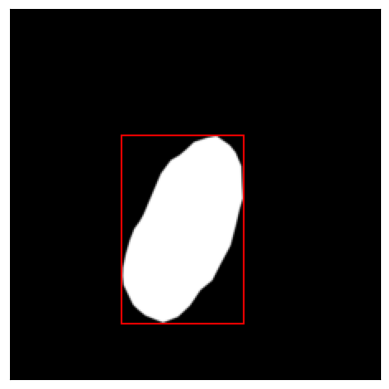

In [7]:
inputs, _, mask, _ = testset[1]
np_mask = mask.numpy()

from scipy import ndimage
com = ndimage.center_of_mass(np_mask)
print(com)

masked_input = inputs * mask
print(masked_input.shape)

from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(mask)
print(boxes)
from torchvision.utils import draw_bounding_boxes

boxes = boxes.type(torch.uint8)
mask = (mask*255).type(torch.uint8)
mask_with_box = draw_bounding_boxes(mask, boxes, colors="red")
# mask_with_box = (mask_with_box*255).type(torch.uint8)
show(mask_with_box)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 114, 74])


(-0.5, 223.5, 223.5, -0.5)

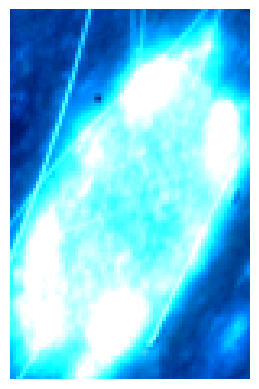

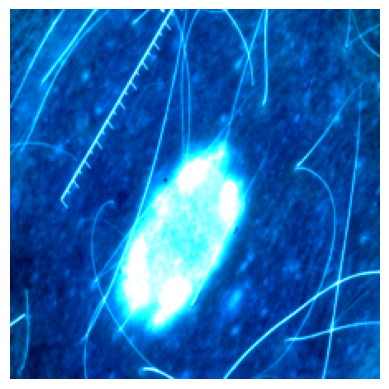

In [8]:
croped_img = F2.crop(inputs, boxes[0][1],boxes[0][0],boxes[0][3]-boxes[0][1],boxes[0][2]-boxes[0][0])
print(croped_img.shape)

plt.figure()
plt.imshow(croped_img.permute(1,2,0))
plt.axis(False)

background = torch.zeros_like(inputs)
background[:,boxes[0][1]:boxes[0][3],boxes[0][0]:boxes[0][2]] = croped_img
# print(background[:,boxes[0][0]:boxes[0][2],boxes[0][1]:boxes[0][3]].shape)
plt.figure()
plt.imshow(inputs.permute(1,2,0))
plt.axis(False)
# plt.imshow(background.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

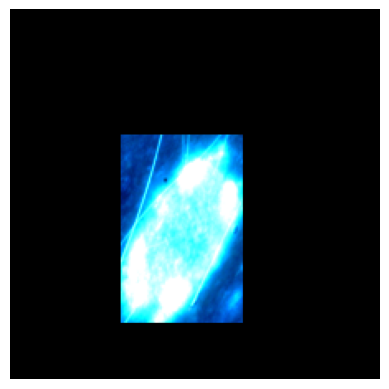

In [9]:
plt.figure()
plt.imshow(background.permute(1,2,0))
plt.axis(False)

In [24]:
model_path = '/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/HAM10000/seed0/baseline/ACC_77.16.pth'
# model_path = '/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/isic/seed0/Mask_ALL2_2/ACC_81.33.pth'
d_path = '/ailab_mat/dataset/ISIC_skin_disease/sample/sample1.jpg'
# d_path = '/ailab_mat/dataset/ISIC_skin_disease/Test_v2/ISIC-2017_Test_v2_Data/ISIC_0012092.jpg'
# d_path = '/ailab_mat/dataset/HAM10000/test/mel/ISIC_0034573.jpg'
# d_path = '/ailab_mat/dataset/HAM10000/train/mel/ISIC_0024310.jpg'

model = models.resnet50()
model.fc = nn.Linear(2048, 3)
return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)
model.load_state_dict(torch.load(model_path))

image = Image.open(d_path)
print(image.size)
width, height = image.size
IMG = image

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
            [transforms.Resize((224,224)),
            transforms.RandomInvert(p=1.0),
            transforms.ToTensor(),
            normalize,
            ])
model.eval()
image = transform(image)
if image.shape[0] != 1:
    image = image.unsqueeze(0)
image = image.to(device)
print(image.shape)
outputs = model(image)
f4 = outputs['l4']
_, pred = torch.max(outputs['fc'], 1)
print(f4.shape)
print(pred.item())

(600, 450)
torch.Size([1, 3, 224, 224])
torch.Size([1, 2048, 7, 7])
2


In [11]:
print(list(model.parameters())[-2].shape)

torch.Size([3, 2048])


torch.Size([450, 600])


(-0.5, 599.5, 449.5, -0.5)

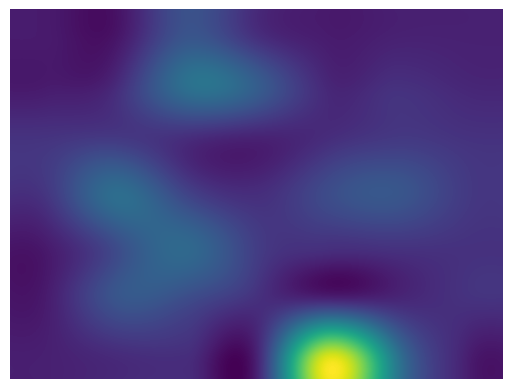

In [12]:
feat = torch.reshape(f4, [-1,2048,7*7])
weights = list(model.parameters())[-2]
weight = weights[int(pred.item())]
weight = weight.unsqueeze(0).unsqueeze(0)

cam = torch.bmm(weight, feat)
cam = torch.reshape(cam, (1,7,7))
cam = cam-torch.min(cam)
cam = cam/torch.max(cam)
# cam = torch.sigmoid(cam)
cam = cam.unsqueeze(1)
cam = F.interpolate(cam, size=(height, width), mode='bicubic')
cam = cam.squeeze()

print(cam.shape)
plt.figure()
plt.imshow(cam.detach().cpu())
plt.axis(False)

torch.Size([450, 600])


(-0.5, 599.5, 449.5, -0.5)

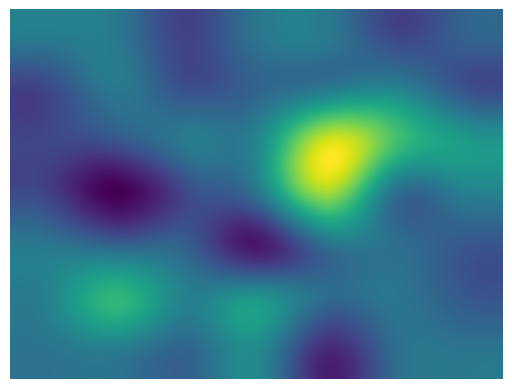

In [13]:
feat = torch.reshape(f4, [-1,2048,7*7])
weights = list(model.parameters())[-2]
caam = torch.zeros((height, width)).to(device)
for i in range(len(weights)):
    weight = weights[i]
    weight = weight.unsqueeze(0).unsqueeze(0)

    cam = torch.bmm(weight, feat)
    cam = torch.reshape(cam, (1,7,7))
    cam = cam-torch.min(cam)
    cam = cam/torch.max(cam)
    # cam = torch.sigmoid(cam)
    cam = cam.unsqueeze(1)
    cam = F.interpolate(cam, size=(height, width), mode='bicubic')
    cam = cam.squeeze()
    caam += cam
caam = caam-torch.min(caam)
caam = caam/torch.max(caam)

print(caam.shape)
plt.figure()
plt.imshow(caam.detach().cpu())
plt.axis(False)

(450, 600, 3)
(450, 600)
torch.Size([224, 224])
torch.Size([450, 600])
torch.Size([1, 1, 450, 600])


(-0.5, 599.5, 449.5, -0.5)

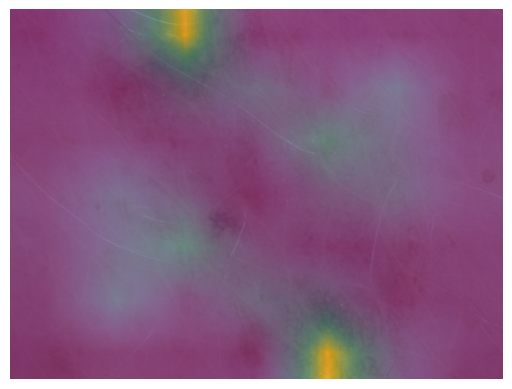

In [36]:
# print(cam.shape)
# print(IMG.size)
np_IMG = np.array(IMG)
np_caam = cam.detach().cpu().numpy()
print(np_IMG.shape)
print(np_caam.shape)
am = gen_am(image, model)
print(am.shape)
am = am.unsqueeze(0).unsqueeze(0)
am = F.interpolate(am, [450, 600])
am = am.squeeze()

print(am.shape)
refine_am = am + F2.rotate(am.unsqueeze(0).unsqueeze(0), angle=180)
print(refine_am.shape)
refine_am = refine_am.squeeze()
# plt.figure()
# plt.imshow(IMG)
# plt.axis(False)

fig, ax = plt.subplots()
ax.imshow(IMG)
ax.imshow(refine_am.detach().cpu(), alpha=0.6)
ax.axis(False)

In [15]:
import torchvision.models as models
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

model = models.resnet18()
train_nodes, eval_nodes = get_graph_node_names(models.resnet18())
print(train_nodes)
return_nodes = {
    'layer1':'layer1',
    'layer2':'layer2',
    'layer3':'layer3',
    'layer4':'layer4',
    'fc':'fc'
}
body = create_feature_extractor(model, return_nodes=return_nodes)

import torch
x = torch.randn([2,3,224,224])
out = body(x)
print(type(out))
# print(out['fc'].shape)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

In [ ]:
import json

with open('/ailab_mat/dataset/bdd100k/bdd100k_labels_images_train.json', 'r') as f:
    train_annot = json.load(f)
    
for anno in train_annot:
    if anno['name'] == '5e852617-49aecd0b.jpg':
        print(anno['labels'])

[{'category': 'person', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 12.044518, 'y1': 226.462338, 'x2': 82.919468, 'y2': 337.837263}, 'id': 1030879}, {'category': 'person', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 838.918949, 'y1': 243.337328, 'x2': 874.356424, 'y2': 326.024771}, 'id': 1030880}, {'category': 'person', 'attributes': {'occluded': True, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 59.294485, 'y1': 226.462338, 'x2': 101.481955, 'y2': 329.399767}, 'id': 1030881}, {'category': 'person', 'attributes': {'occluded': True, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 692.10655, 'y1': 243.337328, 'x2': 725.856527, 'y2': 324.337273}, 'id': 103

In [ ]:
import os, sys
from glob import glob

filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Training/source/*.jpg')
train_list = []
for name in filelist:
    if 'left' in name or 'right' in name:
        continue
    else:
        train_list.append(name.split('/')[-1].split('.')[0])
        
filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Validation/source/*.jpg')
val_list = []
for name in filelist:
    if 'left' in name or 'right' in name:
        continue
    else:
        val_list.append(name.split('/')[-1].split('.')[0])

train_list.sort()
val_list.sort()

print(len(train_list))
print(len(val_list))
print(train_list[:5])
print(val_list[:5])

4440
4440
['08_102940_220615_01', '08_102940_220615_02', '08_102940_220615_03', '08_102940_220615_04', '08_102940_220615_05']
['08_085504_221103_01', '08_085504_221103_02', '08_085504_221103_03', '08_085504_221103_04', '08_085504_221103_05']


In [17]:
# CAM, MASK로 부족한 부분의 Point 생성
# 1. Mask - CAM
# 2. Center of Remain Region
import skimage
import cv2

def get_point(Mask, CAM, tr=0.7):
    assert Mask.shape==CAM.shape 
    binary_cam = CAM.clone()
    binary_cam[binary_cam>=tr] = 1
    binary_cam[binary_cam<tr] = 0
    
    remain = Mask * (1 - binary_cam)
    lbl_0 = skimage.measure.label(remain.detach().cpu().numpy())
    props = skimage.measure.regionprops(lbl_0)
    
    max_contour = None
    max_area = 0
    for prop in props:
        area = prop.area
        if area > max_area:
            max_area = area
            max_contour = prop
            
    cy, cx = max_contour.centroid
    return binary_cam, (cx, cy)

In [18]:
# img, point, scale로 crop 된 이미지 생성
def get_scaled_cropped_img(img, point, scale=2.0):
    height, width = img.shape[-2], img.shape[-1]
    s_height, s_width = height/scale, width/scale
    lx, rx = int(point[0] - s_width/2), int(point[0] + s_width/2)
    ty, by = int(point[1] - s_height/2), int(point[1] + s_height/2)
    
    if lx <= 0: lx = 0
    if ty <= 0: ty = 0
    if rx >= width: rx = width-1
    if by >= height: by = height-1
    
    scaled_cropped_img = F2.resized_crop(img, ty, lx, by-ty, rx-lx, [height, width])
    # print(scaled_cropped_img.shape)
    return scaled_cropped_img, [ty, lx, by-ty, rx-lx]

In [19]:
def gen_caam(inputs, model):
    model.eval()
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    f4 = outputs['l4']

    height, width = inputs.shape[-2], inputs.shape[-1]
    feat = torch.reshape(f4, [-1,2048,7*7])
    weights = list(model.parameters())[-2]
    caam = torch.zeros((height, width)).to(device)
    for i in range(len(weights)):
        weight = weights[i]
        weight = weight.unsqueeze(0).unsqueeze(0)
        cam = torch.bmm(weight, feat)
        # print(cam.shape)
        cam = torch.reshape(cam, (1,7,7))
        cam = cam-torch.min(cam)
        cam = cam/torch.max(cam)
        # cam = torch.sigmoid(cam)
        cam = cam.unsqueeze(1)
        # print(caam[:1,:1])
        cam = F.interpolate(cam, size=(height, width), mode='bilinear')
        cam = cam.squeeze()
        caam += cam
        
    caam = caam-torch.min(caam)
    caam = caam/torch.max(caam)
    return caam

In [18]:
# Activation map
def gen_am(inputs, model):
    # model.eval()
    inputs = inputs.to(device)
    outputs = model(inputs)
    f4 = outputs['l4']

    height, width = inputs.shape[-2], inputs.shape[-1]
    AM = torch.avg_pool1d(f4.squeeze().permute(1,2,0), 2048)
    AM = AM.squeeze()
    AM = AM.unsqueeze(0).unsqueeze(0)
    AM = F.interpolate(AM, size=(height, width), mode='bilinear')
    
    AM = torch.softmax(AM, dim=-1)
    AM = AM-torch.min(AM)
    AM = AM/torch.max(AM)
    
    AM = AM.squeeze()
    # print(AM.shape)
    return AM

In [39]:
# zoom된 caam을 기존 caam에 concat하여 하나로 합침
def concat_ams(caams, boxes, point):
    height, width = caams[0].shape[-2], caams[0].shape[-1]
    final_caam = torch.zeros([height, width]).to(device)
    for box, caam in zip(boxes, caams):
        h, w = box[2], box[3]
        caam = F2.resize(caam.unsqueeze(0).unsqueeze(0), [h, w])
        caam = caam.squeeze()
        final_caam[box[0]:box[0]+box[2], box[1]:box[1]+box[3]] += caam
        # final_caam[box[0]:box[0]+box[2], box[1]:box[1]+box[3]] /= 1.0
        final_caam = torch.clamp(final_caam, min=0, max=1.0)
    # final_caam = torch.softmax(final_caam, dim=-1)
    # final_caam = final_caam-torch.min(final_caam)
    # final_caam = final_caam/torch.max(final_caam)
    # final_caam = torch.sigmoid(final_caam)
    return final_caam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

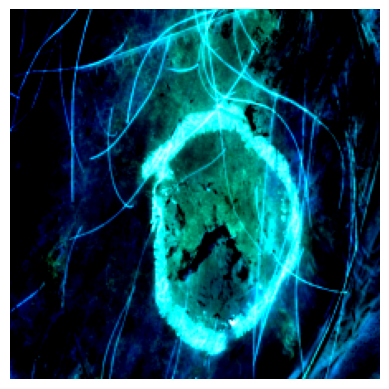

In [47]:
dpath = '/ailab_mat/dataset/ISIC_skin_disease'
testset = ISIC2017(dpath, 'Test', None)
# dpath = '/ailab_mat/dataset/HAM10000'
# testset = HAM10000(dpath, 'test')
testloader = DataLoader(testset, 1, shuffle=False, num_workers=4)
inputs, _, mask, _ = testset[31]
inputs = inputs.unsqueeze(0)
mask = mask.squeeze()
mask = mask.to(device)

model = models.resnet50()
model.fc = nn.Linear(2048, 3)

return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)
model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/HAM10000/seed0/baseline/model_76.16_67.33.pth'))
model.train()
# caam = gen_caam(inputs, model)
am = gen_am(inputs, model)

# # print(caam.shape, mask.shape)
bn_cam, center = get_point(mask, am, tr=0.5)
print(inputs.shape)
scaled_cropped_img_2x, box_2x = get_scaled_cropped_img(inputs, center, scale=2)
scaled_cropped_img_3x, box_3x = get_scaled_cropped_img(inputs, center, scale=3)
scaled_cropped_img_4x, box_4x = get_scaled_cropped_img(inputs, center, scale=4)

scaled_caam_2x = gen_am(scaled_cropped_img_2x, model)
scaled_caam_3x = gen_am(scaled_cropped_img_3x, model)
scaled_caam_4x = gen_am(scaled_cropped_img_4x, model)


box_1x = [0,0,inputs.shape[2]-1,inputs.shape[3]-1]

caams = [am, scaled_caam_2x,scaled_caam_3x]
boxes = [box_1x,box_2x,box_3x]

# caams = [caam,scaled_caam_3x]
# boxes = [box_1x,box_3x]

concated_am = concat_ams(caams, boxes, center)

fig, ax = plt.subplots()
ax.imshow(inputs.squeeze().permute(1,2,0).detach().cpu())
# ax.imshow(scaled_cropped_img_2x.squeeze().permute(1,2,0).detach().cpu())
# ax.imshow(am.detach().cpu(), alpha=0.5)
# ax.imshow(scaled_caam_2x.detach().cpu(), alpha=0.5)
# ax.imshow(concated_am.detach().cpu(), alpha=0.5)
# ax.imshow(bn_cam.detach().cpu(), alpha=0.8)
# ax.imshow(mask.detach().cpu(), alpha=0.8)
# ax.plot([center[0]], center[1], 'ro')
ax.axis(False)

In [146]:
from torch.utils.data import WeightedRandomSampler, SubsetRandomSampler, Subset

#bkl : 90
#mel : 117
#nv : 393
# b:m:n = 30:39:131
# wb:wm:wn = 1/3 : 1/4 : 1:13
path = '/ailab_mat/dataset/ISIC_skin_disease'
mode = 'Test'

# if mode=='Test': mode='Test_v2'
# csv_path = os.path.join(path, mode, f'ISIC-2017_{mode}_Part3_GroundTruth.csv')
# with open(csv_path, 'r', newline='') as f:
#             gt = csv.reader(f)
#             classes = next(iter(gt))[1:]
#             gt = list(gt)
# # print(gt)
# count = [0,0,0]
# for i in range(len(gt)):
#     if int(float(gt[i][1])) == 1:
#         count[1] += 1
#     elif int(float(gt[i][2])) == 1:
#         count[0] += 1
#     else:
#         count[2] += 1
# print(count)

testset = ISIC2017(dpath, 'Validation', None)
# testSampler = WeightedRandomSampler([1/3,1/4,1/13], 10)
data_len = len(testset)
weight = torch.zeros([data_len])

count = [0,0,0]
for i in range(data_len):
    _, label, _, _ = testset[i]
    count[label] += 1
for i in range(data_len):
    _, label, _, _ = testset[i]
    weight[i] = 1/count[label]
    
print(weight[:10])

# unselected_idx = [2*i for i in range(600//2)]
# weight[unselected_idx] = 0
# print(weight)
testSampler = WeightedRandomSampler(weight, replacement=True, num_samples=60)
# print(len(testset))
# print(len(testSampler))
# weighted_testloader = DataLoader(testset, batch_size=1, shuffle=True)
weighted_testloader = DataLoader(testset, batch_size=1, shuffle=False, sampler=testSampler)

for i in range(3):
    count = [0,0,0]
    for image, label, _, _ in weighted_testloader:
        count[label.item()] += 1
    print(count)


tensor([0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128,
        0.0128])
[15, 23, 22]
[17, 22, 21]
[20, 23, 17]


In [150]:
count = torch.load('./count.pth')
weight = torch.load('./weight.pth')

print(count)
print(weight)


[42, 30, 78]
tensor([0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128,
        0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128,
        0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0128, 0.0333, 0.0128,
        0.0128, 0.0128, 0.0238, 0.0333, 0.0128, 0.0128, 0.0128, 0.0128, 0.0238,
        0.0128, 0.0238, 0.0128, 0.0128, 0.0238, 0.0128, 0.0333, 0.0128, 0.0128,
        0.0128, 0.0128, 0.0238, 0.0238, 0.0128, 0.0238, 0.0333, 0.0238, 0.0238,
        0.0128, 0.0128, 0.0128, 0.0128, 0.0238, 0.0128, 0.0128, 0.0238, 0.0128,
        0.0238, 0.0128, 0.0128, 0.0128, 0.0128, 0.0238, 0.0128, 0.0128, 0.0128,
        0.0238, 0.0333, 0.0238, 0.0333, 0.0333, 0.0333, 0.0128, 0.0333, 0.0128,
        0.0128, 0.0238, 0.0238, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0128,
        0.0333, 0.0238, 0.0128, 0.0238, 0.0333, 0.0238, 0.0238, 0.0238, 0.0128,
        0.0128, 0.0128, 0.0238, 0.0333, 0.0333, 0.0238, 0.0238, 0.0333, 0.0333,
        0.0238, 0.0238, 0.0